## Run a `GMM`-`AffineMode` model on the 9-12-removed dataset

In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
from kpsn.models.morph import affine_mode as afm
from kpsn.models.morph import scalar 
from kpsn.models.pose import gmm
from kpsn.models import joint_model
from kpsn.fitting import em
from kpsn import models
from kpsn import util
from kpsn.models import pose
from kpsn.util import pca
from kpsn.util import keypt_io
from kpsn.util import alignment

import kpsn_test.visualize as viz

import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
from jax import config
config.update("jax_debug_nans", True)

### Load data

In [5]:
metadata, keypts = keypt_io.npy_dataset("../../../data_explore/data/")

# operate on a subset of the data without some redundancy
# since we don't care about dynamics anyway
keypts = keypt_io.subsample_time(keypts, 15)

# rotate subject to standard orientation
align_result = alignment.sagittal_align(keypts)
metadata, align_result = keypt_io.select_subset(metadata, align_result, [
    i_subj for i_subj in range(len(align_result))
    if (not metadata['age'][i_subj] in [9, 12])
])

gt_obs = pose.Observations(
    keypt_io.to_feats(util.computations.restack(align_result))[:, :],
    util.computations.stack_ixs(align_result))

### Set up model

In [6]:
N = len(align_result)
M = gt_obs.keypts.shape[1]
eps = 0.05
morph_hyperparams = afm.AffineModeMorphHyperparams(
    N = N, M = M, L = 1,
    modes=None, update_scale = 0.3)
pose_hyperparams = gmm.GMMHyperparams(
    N = N, M = M, L = 5, eps = eps,
    pop_weight_uniformity = 10,
    subj_weight_uniformity = 100)
model = joint_model.JointModel(morph = afm.AffineModeMorph, posespace = gmm.GMMPoseSpaceModel)
hyperparams = joint_model.JointHyperparams(morph = morph_hyperparams, posespace = pose_hyperparams)

In [7]:
init_params = joint_model.init(
    model,
    hyperparams,
    gt_obs,
    reference_subject = 0,
    posespace_kws = dict(
        fit_to_all_subj = True,
        subsample = 0.1)
)

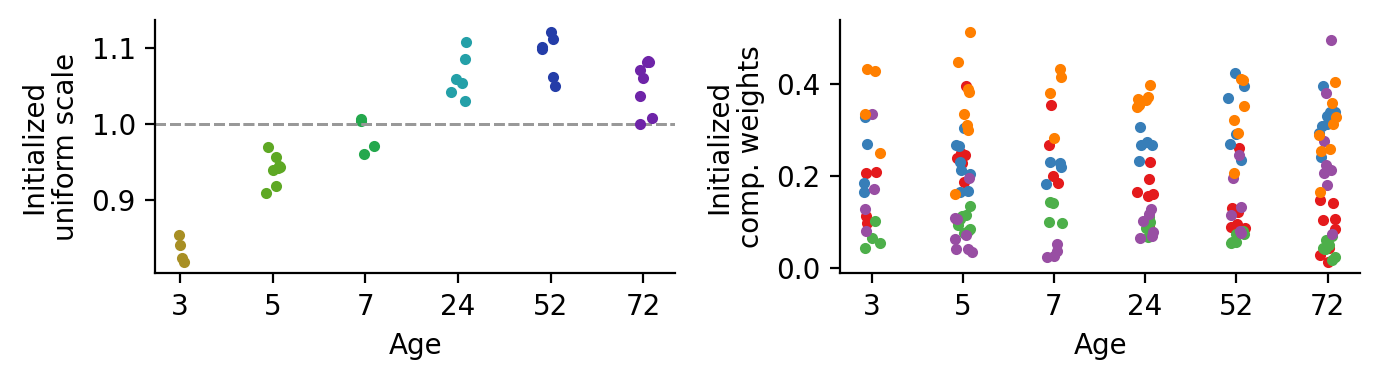

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (7, 2))

jitter = 0.1
ages, age_groups = keypt_io.get_groups(metadata, 'age')
age_pal = dict(zip(ages, sns.hls_palette(l = 0.4, n_colors = len(ages) + 2)[1:-1]))
comp_pal = sns.color_palette('Set1', hyperparams.posespace.L)

for i_age, (age, age_group) in enumerate(zip(ages, age_groups)):
    ax[0].axhline(1, ls = '--', color = '.6', lw = 1)
    ax[0].plot(
        np.random.uniform(-jitter, jitter, len(age_group)) + i_age,
        jnp.exp(init_params.morph.uniform_scale()[age_group]),
        'o', ms = 3, color = age_pal[age])
    for i_comp in range(hyperparams.posespace.L):
        ax[1].plot(
            np.random.uniform(-jitter, jitter, len(age_group)) + i_age,
            init_params.posespace.weights()[age_group, i_comp],
            'o', ms = 3, color = comp_pal[i_comp],
        )

for i in [0,1]: 
    ax[i].set_xticks(np.arange(len(ages)))
    ax[i].set_xticklabels(ages)
    ax[i].set_xlabel("Age")
ax[0].set_ylabel("Initialized\nuniform scale")
ax[1].set_ylabel("Initialized\ncomp. weights")
sns.despine()
plt.tight_layout()
plt.show()

### Fit model

In [10]:
loss_hist, fit_params, mstep_losses, param_hist, trace = em.iterate_em(
    model = model,
    init_params = init_params,
    emissions = gt_obs,
    hyperparams = hyperparams,
    n_steps = 30,
    log_every = -1,
    progress = True,
    tol = None,
    batch_size = 30,
    mstep_log_every = 1,
    mstep_n_steps = 150,
    mstep_learning_rate = 2e-3,
    mstep_tol = 1e-7,
    mstep_stop_window = 25,
    return_mstep_losses = True,
    return_param_hist = True,
    return_reports = True
)

  0%|          | 0/30 [00:00<?, ?it/s]

: 

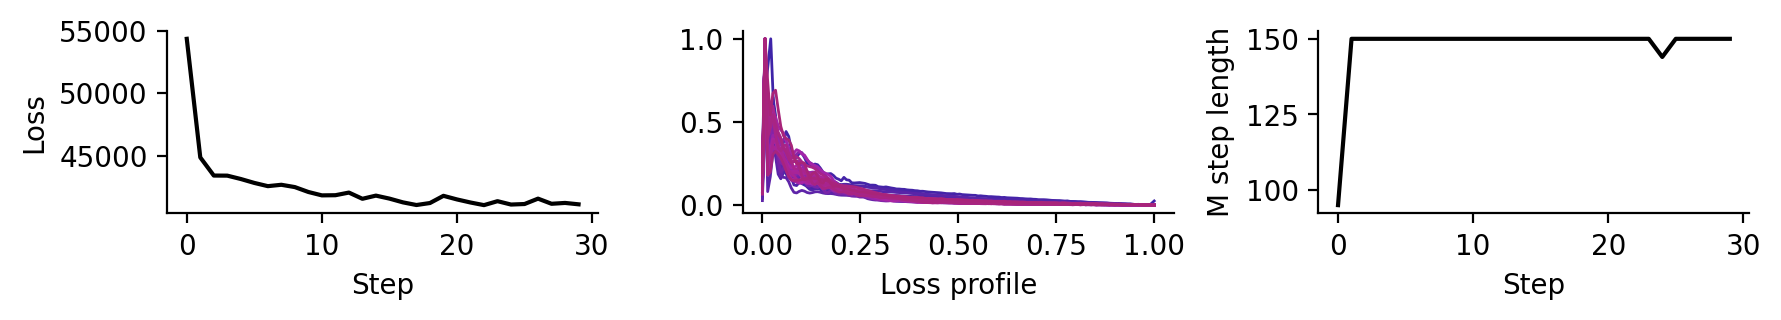

In [19]:
fig, ax = plt.subplots(figsize = (9, 1.7), ncols = 3)
ax[0].plot(loss_hist, 'k-')
pal = sns.hls_palette(len(mstep_losses) * 5, h = 0.7, l = 0.4)[:len(mstep_losses)]
lw = np.linspace(1, 1, len(mstep_losses))
mstep_lengths = []
for i in range(0, len(mstep_losses)):
    if np.any(~np.isfinite(mstep_losses[i])):
        curr_loss = mstep_losses[i][:np.argmax(~np.isfinite(mstep_losses[i]))]
        if len(curr_loss) == 0: continue
    else:
        curr_loss = mstep_losses[i]
    mstep_lengths.append(len(curr_loss))
    ax[1].plot(
        np.linspace(0, 1, len(curr_loss)),
        (curr_loss - curr_loss.min()) / (curr_loss.max() - curr_loss.min()),
        color = pal[i], lw = lw[i])
ax[2].plot(np.arange(len(mstep_lengths)), mstep_lengths, 'k-')
ax[1].set_xlabel("Loss profile")
ax[2].set_ylabel("M step length")
ax[2].set_xlabel("Step")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Step")
plt.tight_layout()
sns.despine()

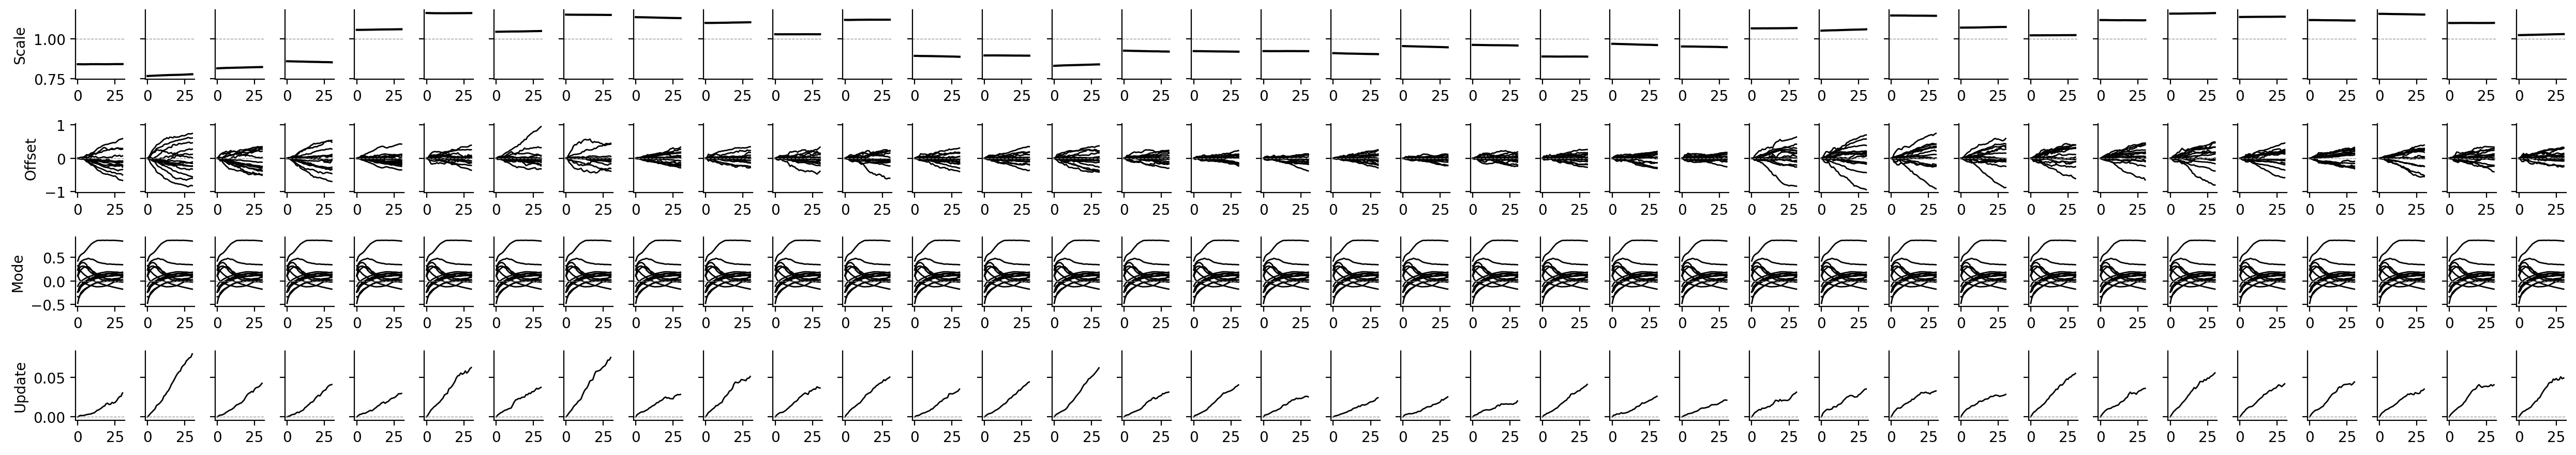

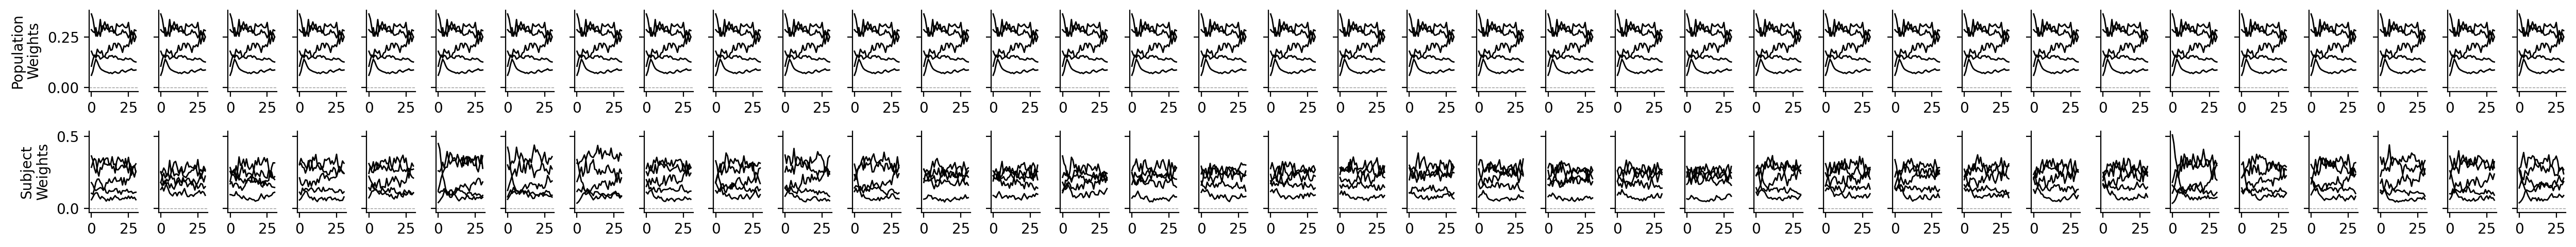

In [20]:
scale_hist = np.stack([p.morph.uniform_scale() for p in param_hist])
ofs_hist = np.stack([p.morph.offsets() for p in param_hist])
mode_hist = np.stack([p.morph.modes() for p in param_hist])
update_hist = np.stack([p.morph.updates() for p in param_hist])

pop_weight_hist = np.stack([p.posespace.pop_weights() for p in param_hist])
subj_weight_hist = np.stack([p.posespace.weights() for p in param_hist])

fig, ax = plt.subplots(4, hyperparams.morph.N, figsize = (25, 4.5), sharey = 'row')
for subj_i in range(hyperparams.morph.N):
    ax[0, subj_i].plot(np.exp(scale_hist[:, subj_i]), 'k-')
    ax[0, subj_i].axhline(1, ls = '--', color = '.6', lw = 0.5)
    ax[1, subj_i].plot(ofs_hist[:, subj_i], 'k-', lw = 1)
    ax[2, subj_i].plot(mode_hist[:, :, 0], 'k-', lw = 1)
    ax[3, subj_i].plot(jnp.linalg.norm(update_hist[:, subj_i, :, 0], axis=1), 'k-', lw = 1)
    for i in [1, 2, 3]:
        ax[i, subj_i].axhline(0, ls = '--', color = '.6', lw = 0.5)
ax[0, 0].set_ylabel("Scale")
ax[1, 0].set_ylabel("Offset")
ax[2, 0].set_ylabel("Mode")
ax[3, 0].set_ylabel("Update")
sns.despine()
plt.tight_layout()


fig, ax = plt.subplots(2, hyperparams.morph.N, figsize = (25, 2.5), sharey = 'row')
for subj_i in range(hyperparams.morph.N):
    ax[0, subj_i].plot(pop_weight_hist, 'k-', lw = 1)
    ax[1, subj_i].plot(subj_weight_hist[:, subj_i], 'k-', lw = 1)
    for i in [0, 1]:
        ax[i, subj_i].axhline(0, ls = '--', color = '.6', lw = 0.5)
ax[0, 0].set_ylabel("Population\nWeights")
ax[1, 0].set_ylabel("Subject\nWeights")
sns.despine()
plt.tight_layout()

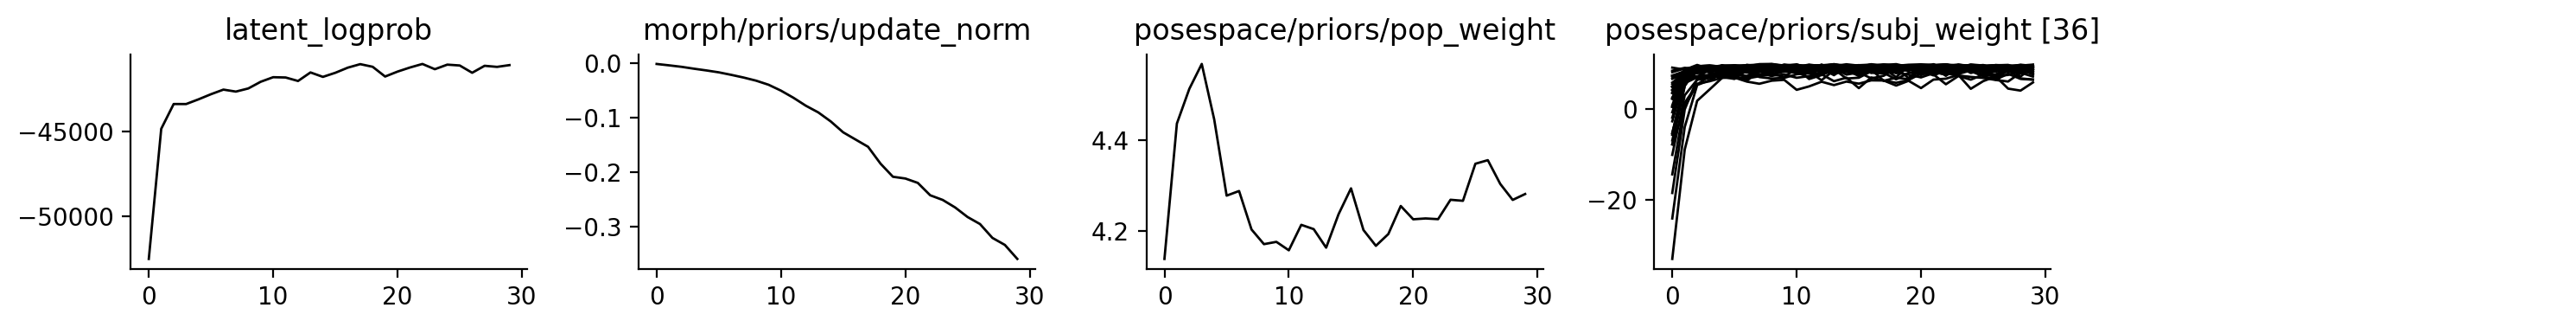

In [21]:
n_col = 5
n_row = int(np.ceil(trace.n_leaves() / n_col))
fig, ax = plt.subplots(n_row, n_col, figsize = (3 * n_col, 2 * n_row))
trace.plot(ax.ravel()[:trace.n_leaves()], color = 'k', lw = 1)
for a in ax.ravel()[trace.n_leaves():]: a.set_axis_off()
sns.despine()
plt.tight_layout()

Reloading 'kpsn.models.morph.affine_mode'.


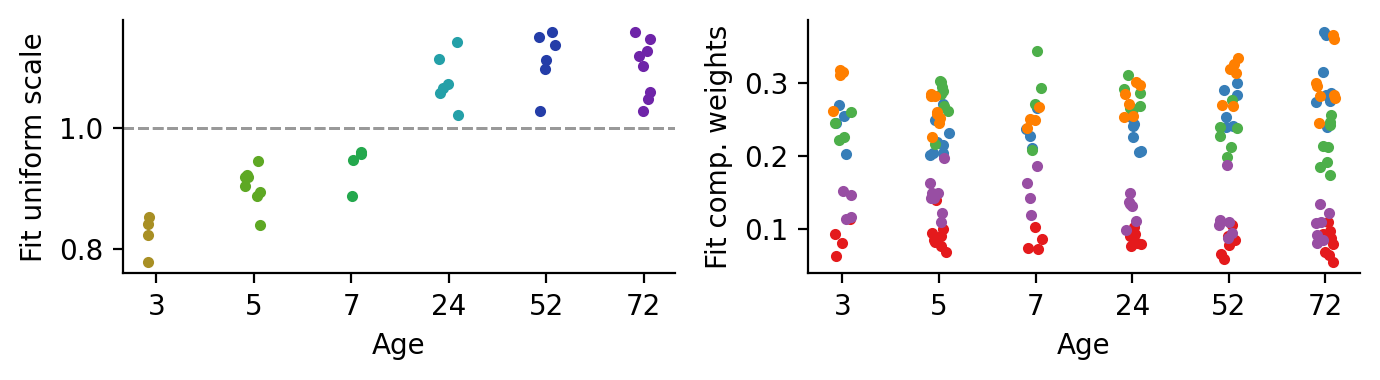

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (7, 2))

jitter = 0.1
ages, age_groups = keypt_io.get_groups(metadata, 'age')
age_pal = dict(zip(ages, sns.hls_palette(l = 0.4, n_colors = len(ages) + 2)[1:-1]))
comp_pal = sns.color_palette('Set1', hyperparams.posespace.L)

for i_age, (age, age_group) in enumerate(zip(ages, age_groups)):
    ax[0].axhline(1, ls = '--', color = '.6', lw = 1)
    ax[0].plot(
        np.random.uniform(-jitter, jitter, len(age_group)) + i_age,
        jnp.exp(fit_params.morph.uniform_scale()[age_group]),
        'o', ms = 3, color = age_pal[age])
    for i_comp in range(hyperparams.posespace.L):
        ax[1].plot(
            np.random.uniform(-jitter, jitter, len(age_group)) + i_age,
            fit_params.posespace.weights()[age_group, i_comp],
            'o', ms = 3, color = comp_pal[i_comp],
        )

for i in [0,1]: 
    ax[i].set_xticks(np.arange(len(ages)))
    ax[i].set_xticklabels(ages)
    ax[i].set_xlabel("Age")
ax[0].set_ylabel("Fit uniform scale")
ax[1].set_ylabel("Fit comp. weights")
sns.despine()
plt.tight_layout()
plt.show()


### Visualizations

In [23]:
# Calculate in-sample poses for each morph direction
all_poses = model.morph.pose_mle(
    gt_obs, fit_params.morph, hyperparams.morph) # (Nt, M)
coords, components, complement = afm.mode_components(
    fit_params.morph, hyperparams.morph, all_poses)
mode_display = fit_params.morph.modes() * jnp.quantile(coords, 0.8, axis = 0)[None] # (M, L)

In [ ]:
plot_subset = [age_group[0] for age_group in age_groups]
xaxis = 0; yaxis = 2

fig, ax = plt.subplots(hyperparams.morph.L + 1, len(plot_subset),
    figsize = (2 * len(plot_subset), 2 * (hyperparams.morph.L + 1)),
    sharex = 'row', sharey = 'row')

for a in ax[1:].ravel():
    viz.diagram_plots.plot_mouse(
        keypt_frame = centroid_pose.reshape(14, 3),
        xaxis = xaxis, yaxis = yaxis,
        scatter_kw = dict(color = '.6'),
        line_kw = dict(linestyle='-', color = '.6', lw = 0.5),
        ax = a
    )
    
for i_subj, subj_id in enumerate(plot_subset):
    centroid_pose = centered_pca.from_coords(fit_params.morph.offsets()[subj_id])
    color = age_pal[metadata['age'][subj_id]]
    diagram_plots.plot_mouse(
        keypt_frame = centroid_pose.reshape(14, 3),
        xaxis = xaxis, yaxis = yaxis,
        scatter_kw = dict(color = color),
        line_kw = dict(linestyle='-', color = color, lw = 0.5),
        ax = ax[0, i_subj]
    )
    ax[0, i_subj].set_title(
        f"Subject {subj_id} | {metadata['age'][subj_id]}wk",
        fontsize = 7)
    ax[0, 0].set_ylabel("Centroid pose", fontsize = 6)

    for i_mode in range(hyperparams.morph.L):
        mode_pose = centered_pca.from_coords(model.morph.transform(
            hyperparams.morph, fit_params.morph, mode_display[:, i_mode], subj_id))
        diagram_plots.plot_mouse(
            keypt_frame = mode_pose.reshape(14, 3),
            xaxis = xaxis, yaxis = yaxis,
            scatter_kw = dict(color = color),
            line_kw = dict(linestyle = '-', color = color, lw = 0.5),
            ax = ax[i_mode + 1, i_subj]
        )
        ax[i_mode + 1, 0].set_ylabel("Mode {i_mode}\nadjustment", fontsize = 6)



for a in ax.ravel():
    a.set_xticks([]); a.set_yticks([])
sns.despine(left = True, bottom = True)

In [39]:
a = np.random.randn(3, 3)
A = a + a.T
u, Q = np.linalg.eigh(A)
B = (Q * u[None, :]) @ Q.T
print(A)
print(B)



[[ 0.6062186  -0.72007192  1.65911548]
 [-0.72007192 -2.04222763 -0.17197812]
 [ 1.65911548 -0.17197812 -0.45494729]]
[[ 0.6062186  -0.72007192  1.65911548]
 [-0.72007192 -2.04222763 -0.17197812]
 [ 1.65911548 -0.17197812 -0.45494729]]
